# 🎯 Phishing Website Detection Project

This project aims to build a **Binary Classification** model to detect whether a website is **Phishing** or **Legitimate**, using a dataset containing information about more than 11,000 websites.

## 🧾 Dataset Description:
Each row in the dataset represents a website and contains **30 features** that describe various attributes, such as:
- Presence of an IP address in the URL
- Use of URL shortening services
- Number of subdomains
- Presence of '@' symbol in the URL
- Usage of HTTPS
- Domain registration length
- Alexa ranking, and more...

The last column represents the **label (target)**:
- `1` → **Phishing**
- `-1` → **Legitimate**

## 🛠️ Project Objective:
To implement a **Decision Tree Classifier from scratch, Random Forest, Adaboost** (without using libraries like Scikit-Learn) that:
- Trains on the dataset
- Predicts whether a website is phishing or legitimate
- Evaluates the performance using:
  - **Accuracy**
  - **Confusion Matrix**
  - **Precision, Recall, and F1-Score**



In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



# splitting The dataset into training and testing sets

In [9]:
# This code assumes you have a dataset in CSV format named 'phishing.csv'
# Load the dataset
df = pd.read_csv('phishing.csv')

# Split into features (X) and target (y)
X = df.drop('class', axis=1) 
y = df['class']

# Split into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert DataFrame / Series to NumPy arrays for compatibility with our tree
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


# Entropy and Information Gain

## Entropy

Entropy measures the uncertainty or impurity in a dataset.

$$
H(Y) = - \sum_{i=1}^{c} p_i \log_2 p_i
$$

- \(c\): Number of classes  
- \(p_i\): Probability of class \(i\) in the dataset \(Y\)  

Entropy is 0 when all samples belong to one class (pure), and maximum when classes are evenly distributed.

---

## Information Gain

Information Gain measures the reduction in entropy after a dataset is split on an attribute.

$$
IG(Y, X) = H(Y) - \sum_{v \in \text{Values}(X)} \frac{|Y_v|}{|Y|} H(Y_v)
$$

- \(H(Y)\): Entropy of the parent dataset  
- \(Y_v\): Subset of \(Y\) for which attribute \(X\) has value \(v\)  
- \(|Y_v|\): Number of samples in subset \(Y_v\)  
- \(|Y|\): Number of samples in parent dataset  

Information Gain is used to select the attribute that best splits the data to reduce uncertainty.


## 🧠 Decision Tree - Overview

A **Decision Tree** is a supervised machine learning algorithm used for **classification** and **regression** tasks.

It works by **splitting** the dataset into subsets based on the value of input features, forming a **tree-like structure**:

- Each **internal node** represents a decision based on a feature.
- Each **branch** represents the outcome of that decision.
- Each **leaf node** represents a final prediction (class or value).

The tree selects the best features using metrics like **Information Gain** (based on **Entropy**) to reduce uncertainty at each split.




In [10]:
# ------------------- ENTROPY & INFORMATION GAIN -------------------

def entropy(y):
    """
    Calculate the entropy of a dataset.
    
    Entropy measures the impurity/randomness in the data. 
    - High entropy = mixed classes (lots of uncertainty)
    - Low entropy = mostly one class (little uncertainty)
    - Formula: H(S) = -Σ(p_i * log2(p_i)) where p_i is proportion of class i
    
    Args:
        y: Array of target labels/classes
    
    Returns:
        float: Entropy value (0 = pure, higher = more mixed)
    """
    counts = Counter(y)  # Count occurrences of each class
    total = len(y)       # Total number of samples
    ent = 0
    
    # Calculate entropy using the formula
    for count in counts.values():
        p = count / total        # Probability of this class
        ent -= p * np.log2(p)   # Add to entropy sum
    return ent

def info_gain(y, left_indices, right_indices):
    """
    Calculate information gain from a split.
    
    Information gain tells you how much uncertainty (entropy) you reduce 
    by splitting your data. Higher gain = better split.
    Formula: IG = H(parent) - [weighted average of H(children)]
    
    Args:
        y: Target labels for parent node
        left_indices: Indices of samples going to left child
        right_indices: Indices of samples going to right child
    
    Returns:
        float: Information gain (higher is better)
    """
    # Get the target values for each child split
    y_left = y[left_indices]
    y_right = y[right_indices]
    
    # Calculate parent entropy (before split)
    parent_entropy = entropy(y)
    
    # Get sizes for weighted average
    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)
    
    # Calculate weighted average entropy of children (after split)
    child_entropy = (n_left / n) * entropy(y_left) + (n_right / n) * entropy(y_right)
    
    # Information gain = reduction in entropy
    gain = parent_entropy - child_entropy
    return gain

# ------------------- BEST SPLIT -------------------

def best_split(X, y):
    """
    Find the best feature and threshold to split the data.
    
    Tests all possible splits and returns the one with highest information gain.
    For each feature, tries splitting at each unique value in that feature.
    
    Args:
        X: Feature matrix (samples x features)
        y: Target labels
    
    Returns:
        tuple: (best_feature_index, best_threshold, best_gain)
               Returns (None, None, -1) if no good split found
    """
    best_feature = None
    best_threshold = None
    best_gain = -1  # Initialize to -1 so any positive gain will be better

    n_samples, n_features = X.shape  # Get dataset dimensions

    # Try every feature as a potential split
    for feature in range(n_features):
        values = np.unique(X[:, feature])  # Get all unique values for this feature
        
        # Try splitting at each unique value
        for threshold in values:
            # Split samples based on threshold
            left_indices = np.where(X[:, feature] <= threshold)[0]   # Samples <= threshold
            right_indices = np.where(X[:, feature] > threshold)[0]   # Samples > threshold

            # Skip if split puts all samples on one side (no point in splitting)
            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            # Calculate information gain for this split
            gain = info_gain(y, left_indices, right_indices)

            # Keep track of the best split so far
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold, best_gain

# ------------------- NODE CLASS -------------------

class Node:
    """
    Represents a node in the decision tree.
    
    Can be either:
    - Internal node: has feature, threshold, left and right children
    - Leaf node: has only a value (the predicted class)
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature      # Feature index to split on (None for leaf)
        self.threshold = threshold  # Threshold value for split (None for leaf)
        self.left = left           # Left child node (samples <= threshold)
        self.right = right         # Right child node (samples > threshold)
        self.value = value         # Predicted class (only for leaf nodes)

# ------------------- TREE BUILDING -------------------

def build_tree(X, y, depth=0, max_depth=None):
    """
    Recursively build a decision tree.
    
    Uses a greedy approach: at each node, find the best split and recursively
    build subtrees. Stops when stopping criteria are met.
    
    Args:
        X: Feature matrix for current node
        y: Target labels for current node
        depth: Current depth in tree (for max_depth stopping)
        max_depth: Maximum allowed depth (None = no limit)
    
    Returns:
        Node: Root of the (sub)tree built from this data
    """
    # STOPPING CRITERION 1: All samples have same class (pure node)
    if len(set(y)) == 1:
        return Node(value=y[0])  # Create leaf with the class label
    
    # STOPPING CRITERION 2: Reached maximum depth
    if max_depth is not None and depth >= max_depth:
        # Create leaf with most common class
        most_common = Counter(y).most_common(1)[0][0]
        return Node(value=most_common)

    # Find the best way to split current data
    feature, threshold, gain = best_split(X, y)
    
    # STOPPING CRITERION 3: No information gain from any split
    if gain == 0:
        # Create leaf with most common class
        most_common = Counter(y).most_common(1)[0][0]
        return Node(value=most_common)

    # Split the data based on best feature and threshold
    left_idx = np.where(X[:, feature] <= threshold)[0]   # Indices for left child
    right_idx = np.where(X[:, feature] > threshold)[0]   # Indices for right child

    # Recursively build left and right subtrees
    left = build_tree(X[left_idx], y[left_idx], depth + 1, max_depth)
    right = build_tree(X[right_idx], y[right_idx], depth + 1, max_depth)

    # Return internal node with the split and its children
    return Node(feature, threshold, left, right)

# ------------------- PREDICTION -------------------

def predict_sample(x, node):
    """
    Predict the class for a single sample by traversing the tree.
    
    Starts at root and follows the path based on feature values until
    reaching a leaf node, then returns the leaf's predicted value.
    
    Args:
        x: Single sample (1D array of feature values)
        node: Current node in the tree
    
    Returns:
        Predicted class label
    """
    # BASE CASE: Reached a leaf node
    if node.value is not None:
        return node.value
    
    # RECURSIVE CASE: Internal node - decide which child to follow
    if x[node.feature] <= node.threshold:
        return predict_sample(x, node.left)   # Go left
    else:
        return predict_sample(x, node.right)  # Go right

def predict(X, tree):
    """
    Predict classes for multiple samples.
    
    Args:
        X: Feature matrix (samples x features)
        tree: Root node of the trained decision tree
    
    Returns:
        numpy array: Predicted class labels for each sample
    """
    # Predict each sample individually and return as array
    return np.array([predict_sample(x, tree) for x in X])

In [11]:
# printing the accuracy and classification report
def evaluate_model(y_true, y_pred):
    class_names = ['Legitimate', 'Phishing']  # for labels -1 and 1
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("\n Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(" Confusion Matrix - Phishing Detection")
    plt.show()

In [12]:
def DeceisionTreeClassifier(X_train, y_train, X_test, y_test, max_depth=None):
    """
    Train a Decision Tree Classifier and evaluate its performance.
    
    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Testing features
    - y_test: Testing labels
    - max_depth: Maximum depth of the tree (optional)
    
    Returns:
    - None
    """
    # Build the decision tree
    tree = build_tree(X_train, y_train, max_depth=max_depth)
    # Make predictions on the test set
    y_pred = predict(X_test, tree)
    
    # Evaluate the model
    evaluate_model(y_test, y_pred)

Accuracy: 0.9222

 Classification Report:

              precision    recall  f1-score   support

  Legitimate       0.97      0.85      0.91       976
    Phishing       0.89      0.98      0.93      1235

    accuracy                           0.92      2211
   macro avg       0.93      0.91      0.92      2211
weighted avg       0.93      0.92      0.92      2211



<Figure size 600x500 with 0 Axes>

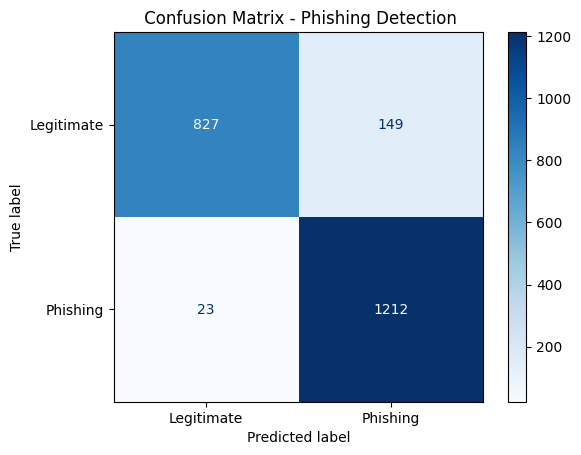

In [13]:
DeceisionTreeClassifier(X_train, y_train, X_test, y_test, max_depth=5)



# 🧠 AdaBoost Algorithm — Phishing Detection Use Case

In this section, we implement the AdaBoost algorithm from scratch using simple decision stumps (i.e., one-level decision rules). AdaBoost is an ensemble learning method that combines multiple weak learners, where each subsequent learner focuses more on the mistakes made by the previous ones. This iterative reweighting helps build a strong final classifier.

🔍 **Key Concepts**:
- Each decision stump makes a basic prediction based on a single feature and threshold.
- Misclassified samples are given more weight so future stumps focus on harder cases.
- Final predictions are a weighted vote of all stumps.

We apply this method to a phishing website detection problem based on a dataset of ~11,000 entries with 30 numerical features. Note that this code is fully implemented from scratch, using no external ML libraries (except for data evaluation).

---

In [14]:

# Define a weak classifier using a dictionary instead of class

def create_decision_stump():
    return {
        'feature_index': None,
        'threshold': None,
        'polarity': 1,
        'alpha': None
    }

def stump_predict(X, stump):
    n_samples = X.shape[0]
    X_column = X[:, stump['feature_index']]
    predictions = np.ones(n_samples)
    if stump['polarity'] == 1:
        predictions[X_column < stump['threshold']] = -1
    else:
        predictions[X_column > stump['threshold']] = -1
    return predictions


def AdaBoost_train(X, y, n_clf=10):
    n_samples, n_features = X.shape
    w = np.ones(n_samples) / n_samples
    stumps = []

    for _ in range(n_clf):
        stump = create_decision_stump()
        min_error = float('inf')

        for feature_i in range(n_features):
            X_column = X[:, feature_i]
            thresholds = np.unique(X_column)

            for threshold in thresholds:
                for polarity in [1, -1]:
                    predictions = np.ones(n_samples)
                    if polarity == 1:
                        predictions[X_column < threshold] = -1
                    else:
                        predictions[X_column > threshold] = -1

                    error = np.sum(w[y != predictions])

                    if error < min_error:
                        stump['polarity'] = polarity
                        stump['threshold'] = threshold
                        stump['feature_index'] = feature_i
                        min_error = error

        EPS = 1e-10
        stump['alpha'] = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))

        predictions = stump_predict(X, stump)
        w *= np.exp(-stump['alpha'] * y * predictions)
        w /= np.sum(w)

        stumps.append(stump)

    return stumps


def AdaBoost_predict(X, stumps):
    clf_preds = [stump['alpha'] * stump_predict(X, stump) for stump in stumps]
    y_pred = np.sum(clf_preds, axis=0)
    return np.sign(y_pred)


# ✅ How it Works:
# 1. We use decision stumps (trees of depth 1) as weak learners.
# 2. Each round, we find the best stump based on weighted error.
# 3. We compute the importance (alpha) of that classifier.
# 4. Update weights so misclassified samples get more weight.
# 5. Final prediction is a weighted vote of all weak classifiers.

---

# Train AdaBoost with decision stumps

In [15]:
stumps = AdaBoost_train(X_train, y_train, n_clf=10)


# Predict

In [16]:
y_pred = AdaBoost_predict(X_test, stumps)

# Evaluate

Accuracy: 0.929

 Classification Report:

              precision    recall  f1-score   support

  Legitimate       0.91      0.93      0.92       976
    Phishing       0.95      0.93      0.94      1235

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211



<Figure size 600x500 with 0 Axes>

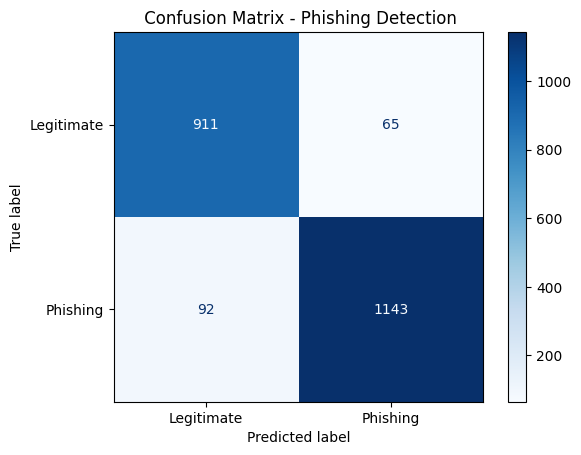

In [17]:
evaluate_model(y_test, y_pred)